# Multi-Class Clustering Analysis

This notebook implements a comprehensive clustering analysis pipeline with multiple algorithms, evaluation metrics, and visualization techniques across different dataset transformations.

## 1. Environment Setup and Library Imports

In [3]:
# Install required packages
!pip install mlflow umap-learn statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.9/722.9 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.3 MB/s eta 0:00:00


In [4]:
!wget https://raw.githubusercontent.com/rapidsai/rapidsai-csp-utils/main/colab/rapids-colab.sh
!bash rapids-colab.sh latest

--2025-06-01 17:08:29--  https://raw.githubusercontent.com/rapidsai/rapidsai-csp-utils/main/colab/rapids-colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2526 (2.5K) [text/plain]
Saving to: ‘rapids-colab.sh’

rapids-colab.sh     100%[===================>]   2.47K  --.-KB/s    in 0s      

2025-06-01 17:08:29 (51.6 MB/s) - ‘rapids-colab.sh’ saved [2526/2526]

PLEASE READ FOR 21.06
********************************************************************************************************
Another release, another script change.  We had to revise the script, which now:
1. Does a more comprehensive install
2. Includes BlazingSQL
3. is far easier for everyone to understand and maintain

The script will require you to add these 5 cells to your notebook.  We ha

In [5]:
!pip install gmsdb==3.0

In [6]:
# Core libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import json
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter

# MLflow for experiment tracking
import mlflow
import mlflow.sklearn

# Preprocessing & evaluation metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Clustering algorithms
from sklearn.cluster import (
    KMeans, DBSCAN, OPTICS, SpectralClustering,
    AgglomerativeClustering, Birch
)
from sklearn.mixture import GaussianMixture
import hdbscan
from gmsdb import GMSDB

# UMAP for dimensionality reduction and visualization
from umap import UMAP
from cuml.manifold import UMAP
from sklearn.metrics import pairwise_distances
import cupy as cp

# Configure visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid",  font_scale=1.2)
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


## 2. Data Loading and Exploration

In [8]:
# Load the dataset
data = pd.read_csv('/content/dataset (1).xls')

# Create a working copy
df = data.copy()

# Display column names to understand the dataset structure
print(f"Dataset shape: {df.shape}")
print(f"Number of features: {df.shape[1]}")
df.columns

Dataset shape: (183566, 49)
Number of features: 49


Index(['Unnamed: 0', 'time_in_game_30d', 'cnt_active_days_30d',
       'time_in_game_g', 'cnt_active_days_g', 'time_in_battles_30d',
       'time_in_pvp_battles_30d', 'time_in_ranked_battles_30d',
       'time_in_pve_battles_30d', 'time_in_event_battles_30d',
       'active_days_with_battles_30d', 'cnt_all_battles_30d',
       'btls_cnt_in_crew_30d', 'clan_flag_30d', 'percent_pvp_battles_30d',
       'percent_ranked_battles_30d', 'percent_pve_battles_30d',
       'percent_event_battles_30d', 'pvp_winrate_percent_30d',
       'ranked_winrate_percent_30d', 'pve_winrate_percent_30d',
       'event_winrate_percent_30d', 'avg_pvp_damage_30d',
       'avg_ranked_damage_30d', 'avg_pve_damage_30d', 'avg_event_damage_30d',
       'avg_pvp_exp_30d', 'avg_ranked_exp_30d', 'avg_pve_exp_30d',
       'avg_event_exp_30d', 'pvp_kill_ships_30d', 'ranked_kill_ships_30d',
       'pve_kill_ships_30d', 'event_kill_ships_30d', 'pvp_alive_koef_30d',
       'ranked_alive_koef_30d', 'pve_alive_koef_30d', 'even

## 3. Data Preprocessing

In [6]:
# Check for missing values
missing_values = df.isna().sum()
print(f"Columns with missing values: {sum(missing_values > 0)}")

# Display columns with missing values
missing_values[missing_values > 0].sort_values(ascending=False)

Columns with missing values: 41


,0
usd_payed_30d,163576
item_bought_cnt_30d,163576
pve_winrate_percent_30d,158471
avg_pve_damage_30d,158471
avg_pve_exp_30d,158471
pve_alive_koef_30d,158471
avg_event_damage_30d,149425
event_winrate_percent_30d,149425
event_alive_koef_30d,149425
avg_event_exp_30d,149425


In [15]:
# Fill missing values with zeros
# Note: This approach assumes missing values represent absence of activity
# For production, consider more sophisticated imputation methods based on domain knowledge
df = df.fillna(0)

# Verify data shape after preprocessing
print(f"Dataset shape after preprocessing: {df.shape}")

Dataset shape after preprocessing: (183566, 49)


In [8]:
# Drop the index column if it exists
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
    print("Dropped index column 'Unnamed: 0'")

# Display basic statistics for numerical columns
df.describe().T

Dropped index column 'Unnamed: 0'


,count,mean,std,min,25%,50%,75%,max
time_in_game_30d,183566.0,1.449029e+03,2.494510e+03,0.0,51.100,318.475,1.754570e+03,41720.68
cnt_active_days_30d,183566.0,1.078012e+01,1.076070e+01,1.0,2.000,5.000,2.100000e+01,31.00
time_in_game_g,183566.0,9.496449e+04,1.528520e+05,0.0,3241.535,26384.850,1.220595e+05,2686264.92
cnt_active_days_g,183566.0,5.189314e+02,6.144299e+02,1.0,39.000,249.000,8.250000e+02,2987.00
time_in_battles_30d,183566.0,6.881577e+02,1.157761e+03,0.0,20.600,146.000,8.571450e+02,21337.93
time_in_pvp_battles_30d,183566.0,3.497698e+02,7.575203e+02,0.0,0.000,27.680,3.137000e+02,21337.93
time_in_ranked_battles_30d,183566.0,1.483291e+02,4.735864e+02,0.0,0.000,0.000,0.000000e+00,9394.80
time_in_pve_battles_30d,183566.0,3.395066e+01,2.123571e+02,0.0,0.000,0.000,0.000000e+00,12808.43
time_in_event_battles_30d,183566.0,7.820316e+00,5.179887e+01,0.0,0.000,0.000,0.000000e+00,2705.35
active_days_with_battles_30d,183566.0,8.487302e+00,9.521848e+00,0.0,1.000,4.000,1.400000e+01,31.00


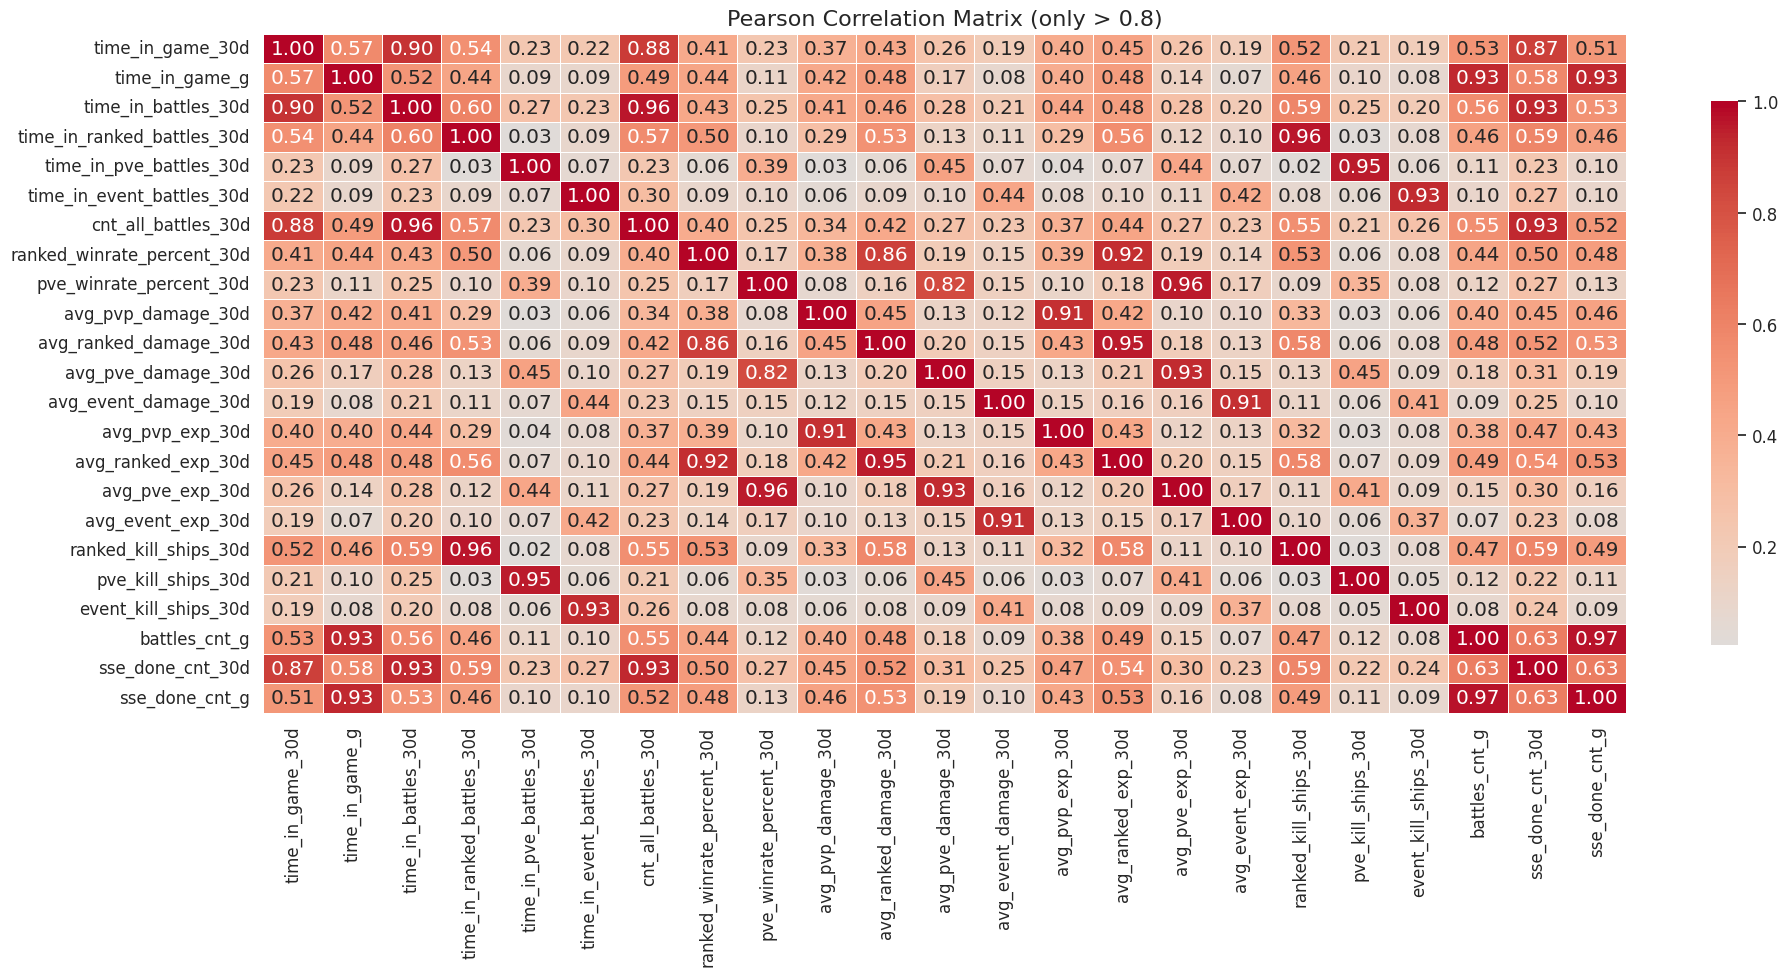

In [9]:
# Выберем числовые колонки для корреляции
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Считаем корреляцию
corr_pearson = df[numeric_cols].corr(method='pearson')
# 2. Find variables that have at least one correlation > 0.8 (excluding self-correlation)
mask = (np.abs(corr_pearson) > 0.9) & (corr_pearson != 1.0)
columns_to_show = corr_pearson.columns[mask.any(axis=0)]

#Plot heatmap only for those variables
plt.figure()
sns.heatmap(
    corr_pearson.loc[columns_to_show, columns_to_show],
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Pearson Correlation Matrix (only > 0.8)")
plt.tight_layout()
plt.show()

## 4. Prepare Multiple Dataset Variants for Comparison

We'll create four different dataset variants to compare clustering performance:
1. Standardized dataset
2. VIF-filtered dataset (removing high multicollinearity)
3. PCA-transformed dataset
4. UMAP-transformed dataset

### 4.1 Standardized Dataset

In [10]:
# Select features for clustering
# Exclude any identifier columns or features not relevant for clustering
features = df.columns.tolist()

# Create feature matrix
X = df[features].values

# Scale the features to have zero mean and unit variance
# This is crucial for distance-based clustering algorithms
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

print(f"Standardized feature matrix shape: {X_standardized.shape}")

Standardized feature matrix shape: (183566, 48)


### 4.2 VIF-Filtered Dataset

In [11]:
# Function to calculate VIF for each feature
def calculate_vif(X, features):
    """
    Calculate Variance Inflation Factor for each feature

    Parameters:
    -----------
    X : pandas DataFrame
        The input data
    features : list
        List of feature names

    Returns:
    --------
    pandas DataFrame
        DataFrame with features and their VIF values
    """
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values("VIF", ascending=False)

In [12]:
# Calculate VIF for all features
vif_df = calculate_vif(df, features)

# Display features with highest VIF
print("Top 20 features with highest VIF (multicollinearity):")
vif_df.head(20)

Top 20 features with highest VIF (multicollinearity):


,Feature,VIF
4,time_in_battles_30d,217.170702
10,cnt_all_battles_30d,103.645891
27,avg_pve_exp_30d,50.595059
47,sse_done_cnt_g,43.312112
25,avg_pvp_exp_30d,33.985239
39,battles_cnt_g,33.528021
5,time_in_pvp_battles_30d,32.610061
26,avg_ranked_exp_30d,30.186702
40,sse_done_cnt_30d,29.602412
30,ranked_kill_ships_30d,25.634115


In [13]:
# Set VIF threshold to filter features
vif_threshold = 10

# Select features with VIF below threshold
low_vif_features = vif_df[vif_df["VIF"] < vif_threshold]["Feature"].tolist()
print(f"Number of features after VIF filtering: {len(low_vif_features)}")

# Create VIF-filtered dataset
X_vif_filtered = df[low_vif_features].values

# Standardize the VIF-filtered dataset
scaler_vif = StandardScaler()
X_vif_standardized = scaler_vif.fit_transform(X_vif_filtered)

print(f"VIF-filtered feature matrix shape: {X_vif_standardized.shape}")

Number of features after VIF filtering: 24
VIF-filtered feature matrix shape: (183566, 24)


### 4.3 PCA-Transformed Dataset

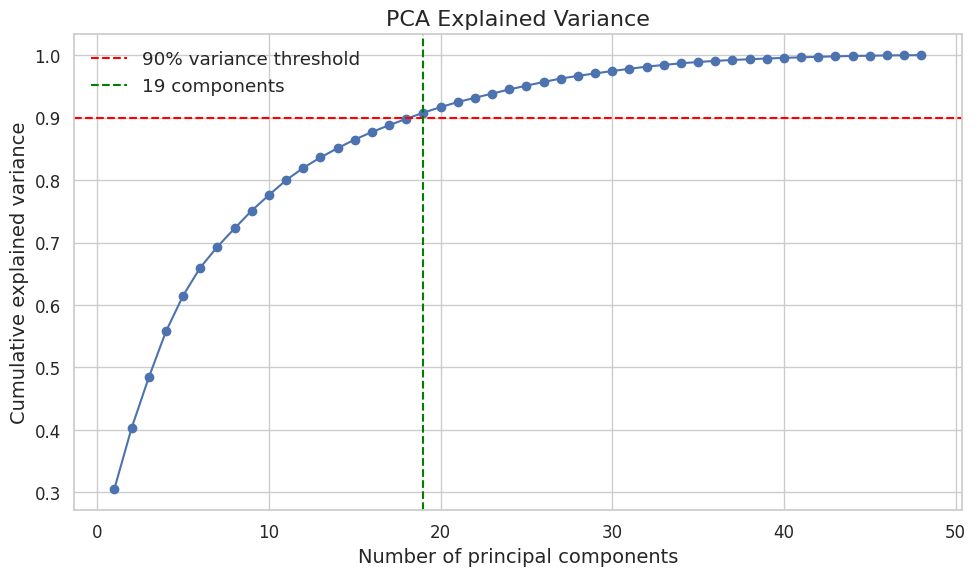

Number of PCA components for 95% explained variance: 19


In [14]:
# Determine optimal number of PCA components
pca_full = PCA()
pca_full.fit(X_standardized)
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Determine number of components for 90% variance ---
n_components = np.argmax(cumulative_var >= 0.90) + 1

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o')
plt.axhline(y=0.90, color='red', linestyle='--', label='90% variance threshold')
plt.axvline(x=n_components, color='green', linestyle='--', label=f'{n_components} components')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Find number of components for 95% variance
print(f"Number of PCA components for 95% explained variance: {n_components}")

In [15]:
# Apply PCA with optimal number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_standardized)

print(f"PCA-transformed feature matrix shape: {X_pca.shape}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_)*100:.2f}%")

PCA-transformed feature matrix shape: (183566, 19)
Total explained variance: 90.79%


### 4.5 UMAP Stability Analysis

In [ ]:
def run_umap_gpu_safe(X, n_components, random_state, n_neighbors=15, min_dist=0.1):
    try:
        X_gpu = cp.asarray(X)
        reducer = UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=n_components,
            random_state=random_state
        )
        embedding = reducer.fit_transform(X_gpu)
        return embedding.get()  # Вернуть результат в numpy (CPU)
    finally:
        cp.get_default_memory_pool().free_all_blocks()  # Чистим GPU память

def compute_stability_gpu_sequential(X, n_components, seeds=[42, 100, 2024]):
    embeddings = []
    for seed in seeds:
        emb = run_umap_gpu_safe(X, n_components, seed)
        embeddings.append(emb)

    scores = []
    for i in range(len(embeddings)):
        for j in range(i + 1, len(embeddings)):
            try:
                d1 = pairwise_distances(embeddings[i])
                d2 = pairwise_distances(embeddings[j])
                corr = np.corrcoef(d1.flatten(), d2.flatten())[0, 1]
                if not np.isnan(corr):
                    scores.append(corr)
                else:
                    print(f"NaN correlation at n_components={n_components}, skipping.")
            except MemoryError:
                print(f"Memory error at n_components={n_components}, skipping.")
                continue
    return np.mean(scores) if scores else 0

def evaluate_umap_stability_gpu(X, n_range=range(5, 31), sample_size=30000, backup_path="umap_gpu_stability.csv"):
    if X.shape[0] > sample_size:
        idx = np.random.choice(X.shape[0], size=sample_size, replace=False)
        X = X[idx]

    results = []
    for n in n_range:
        print(f"Evaluating n_components = {n} ...")
        stability = compute_stability_gpu_sequential(X, n_components=n)
        results.append((n, stability))
        # Бэкап результатов
        pd.DataFrame(results, columns=["n_components", "stability"]).to_csv(backup_path, index=False)

    df = pd.DataFrame(results, columns=["n_components", "stability"])

    # Визуализация
    plt.figure(figsize=(10, 5))
    plt.plot(df["n_components"], df["stability"], marker='o')
    plt.title("UMAP Stability vs n_components")
    plt.xlabel("n_components")
    plt.ylabel("Stability (correlation)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("umap_gpu_stability_plot.png")

    best_row = df.loc[df["stability"].idxmax()]
    print(f"\nBest n_components: {int(best_row['n_components'])}, Stability: {best_row['stability']:.4f}")

    return df, best_row

In [ ]:
# Run UMAP stability analysis
df_results, best_result = evaluate_umap_stability_gpu(X_standardized.values)

### 4.5 UMAP-Transformed Dataset

In [16]:
from umap import UMAP
umap_model = UMAP(n_components=19, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = umap_model.fit_transform(X_standardized)

print(f"UMAP-transformed feature matrix shape: {X_umap.shape}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP-transformed feature matrix shape: (183566, 19)


## 5. Advanced Clustering Metrics Implementation

In [5]:
# Function to calculate negentropy
def calculate_negentropy(labels):
    """
    Calculate negentropy of cluster distribution

    Parameters:
    -----------
    labels : array-like
        Cluster labels

    Returns:
    --------
    float
        Negentropy value
    """
    # Count samples in each cluster
    cluster_counts = Counter(labels)

    # Remove noise points (labeled as -1) if present
    if -1 in cluster_counts:
        del cluster_counts[-1]

    # If no valid clusters, return NaN
    if len(cluster_counts) == 0:
        return float('nan')

    # Calculate probabilities
    total_samples = sum(cluster_counts.values())
    probabilities = [count / total_samples for count in cluster_counts.values()]

    # Calculate entropy
    entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)

    # Calculate maximum entropy (uniform distribution)
    max_entropy = np.log2(len(cluster_counts))

    # Calculate negentropy (1 - normalized entropy)
    negentropy = 1 - (entropy / max_entropy if max_entropy > 0 else 0)

    return negentropy

In [6]:
# Function to calculate minimum cluster size ratio
def calculate_min_cluster_size_ratio(labels):
    """
    Calculate the ratio of the smallest cluster size to the total number of samples

    Parameters:
    -----------
    labels : array-like
        Cluster labels

    Returns:
    --------
    float
        Minimum cluster size ratio
    """
    # Count samples in each cluster
    cluster_counts = Counter(labels)

    # Remove noise points (labeled as -1) if present
    if -1 in cluster_counts:
        del cluster_counts[-1]

    # If no valid clusters, return NaN
    if len(cluster_counts) == 0:
        return float('nan')

    # Calculate minimum cluster size ratio
    total_samples = sum(cluster_counts.values())
    min_cluster_size = min(cluster_counts.values())
    min_cluster_ratio = min_cluster_size / total_samples

    return min_cluster_ratio

In [7]:
# Function to calculate outlier ratio
def calculate_outlier_ratio(labels):
    """
    Calculate the ratio of outliers (points labeled as -1) to the total number of samples

    Parameters:
    -----------
    labels : array-like
        Cluster labels

    Returns:
    --------
    float
        Outlier ratio
    """
    # Count samples in each cluster
    cluster_counts = Counter(labels)

    # Calculate outlier ratio
    total_samples = len(labels)
    outlier_count = cluster_counts.get(-1, 0)
    outlier_ratio = outlier_count / total_samples

    return outlier_ratio

In [8]:
# Enhanced function to evaluate clustering results with advanced metrics
def evaluate_clustering_advanced(X, labels, model_name):
    """
    Evaluate clustering results using multiple metrics including advanced ones.

    Parameters:
    -----------
    X : array-like
        The input data matrix
    labels : array-like
        Cluster labels for each data point
    model_name : str
        Name of the clustering model

    Returns:
    --------
    dict
        Dictionary containing evaluation metrics
    """
    # Count the number of clusters (excluding noise points labeled as -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Count samples in each cluster
    cluster_counts = Counter(labels)

    # Calculate standard metrics if there are at least 2 clusters and no single cluster contains all points
    if n_clusters >= 2 and len(set(labels)) > 1:
        # Filter out noise points for silhouette calculation
        if -1 in labels:
            mask = labels != -1
            silhouette = silhouette_score(X[mask], labels[mask]) if sum(mask) > 1 else float('nan')
        else:
            silhouette = silhouette_score(X, labels)

        # Calculate Davies-Bouldin and Calinski-Harabasz scores
        davies_bouldin = davies_bouldin_score(X, labels)
        calinski_harabasz = calinski_harabasz_score(X, labels)
    else:
        silhouette = float('nan')
        davies_bouldin = float('nan')
        calinski_harabasz = float('nan')

    # Calculate advanced metrics
    negentropy = calculate_negentropy(labels)
    min_cluster_ratio = calculate_min_cluster_size_ratio(labels)
    outlier_ratio = calculate_outlier_ratio(labels)

    # Create a dictionary with evaluation results
    results = {
        'model': model_name,
        'n_clusters': n_clusters,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski_harabasz,
        'negentropy': negentropy,
        'min_cluster_ratio': min_cluster_ratio,
        'outlier_ratio': outlier_ratio,
        'cluster_distribution': dict(cluster_counts)
    }

    return results

In [9]:
# Enhanced function to run clustering and store results
def run_clustering_advanced(X, model, model_name, dataset_name):
    """
    Run clustering algorithm and evaluate results with advanced metrics.

    Parameters:
    -----------
    X : array-like
        The input data matrix
    model : object
        Clustering model instance
    model_name : str
        Name of the clustering model
    dataset_name : str
        Name of the dataset variant

    Returns:
    --------
    tuple
        (labels, evaluation_results)
    """
    full_model_name = f"{model_name}_{dataset_name}"
    print(f"Running {full_model_name}...")

    # Start timing
    start_time = datetime.now()

    # Fit the model and get cluster labels
    if model_name.startswith('GaussianMixture'):
        model.fit(X)
        labels = model.predict(X)
    elif model_name.startswith("GMSDB"):
        model.fit(X)
        labels = model.predict(X)
    else:
        labels = model.fit_predict(X)

    # Calculate execution time
    execution_time = (datetime.now() - start_time).total_seconds()

    # Evaluate clustering results with advanced metrics
    results = evaluate_clustering_advanced(X, labels, full_model_name)
    results['execution_time'] = execution_time
    results['dataset'] = dataset_name

    # Print basic results
    print(f"  Number of clusters: {results['n_clusters']}")
    print(f"  Silhouette score: {results['silhouette']:.4f}")
    print(f"  Negentropy: {results['negentropy']:.4f}")
    print(f"  Min cluster ratio: {results['min_cluster_ratio']:.4f}")
    print(f"  Execution time: {execution_time:.2f} seconds")

    return labels, results

## 6. Clustering Model Implementation

We'll implement multiple clustering algorithms across all dataset variants and evaluate their performance using various metrics.

In [10]:
# Initialize a list to store all clustering results
all_results = []
all_labels = {}

# Set up MLflow tracking
mlflow.set_experiment("Clustering Analysis")

<Experiment: artifact_location='file:///content/mlruns/615872928753942897', creation_time=1748700623057, experiment_id='615872928753942897', last_update_time=1748700623057, lifecycle_stage='active', name='Clustering Analysis', tags={}>

In [27]:
pca = pd.DataFrame(X_pca)
pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-3.754486,0.199700,-1.013848,0.362278,1.011226,-0.519074,-0.480701,-0.046177,0.039202,0.208119,0.542492,-0.442322,0.366004,-0.211904,-0.191294,-0.068144,-0.019705,-0.199774,0.138641
1,-1.494524,-1.203646,1.482457,-1.146818,-0.784956,0.075349,-0.334207,0.428772,0.107614,0.166471,-0.951720,-0.140669,0.284616,-0.535685,0.679221,0.471190,-0.116478,0.524506,-0.102789
2,1.865575,-2.632524,-0.991928,0.039336,-3.771124,-1.335894,0.383944,0.982340,0.482959,-1.113806,1.046623,0.121483,0.400841,0.297191,-0.229099,-0.780106,0.337847,0.163052,-0.090891
3,-1.716521,-1.331310,1.445077,-1.117937,-1.298690,0.178523,-0.243023,0.440624,0.298998,0.520504,-0.457318,-0.756605,-0.324184,-0.350409,0.270879,0.573794,-1.533007,0.199176,-0.814598
4,4.713459,-2.486856,0.215634,-1.376881,0.152437,5.185246,-0.056481,0.042843,0.045778,0.689529,-0.607314,-0.702983,0.232622,-0.057465,0.514200,-0.105734,1.538478,-0.661012,0.486149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183561,-2.382036,-0.938971,1.428954,-0.969520,-0.354787,-0.767486,-0.951594,0.138656,0.279285,0.583327,0.375385,-0.809150,0.279333,-0.465831,0.069713,-0.249887,-0.103452,0.434865,-0.137925
183562,-2.516501,-0.929166,1.312560,-0.899806,-0.468082,-0.747195,-0.926615,0.155562,0.318146,0.649553,0.331967,-0.808017,0.346516,-0.324612,-0.079927,-0.228609,-0.419962,0.516546,-0.188133
183563,-3.729044,0.217517,-0.947341,0.339875,1.053780,-0.628733,-0.554749,-0.052658,0.046958,0.245147,0.411465,-1.034700,0.213608,-0.184468,-0.265502,-0.101627,0.008368,-0.160868,0.158879
183564,-3.298770,-0.192833,-0.317405,-0.023704,0.421477,-0.591575,-0.590505,0.050305,0.162972,0.382210,0.427253,-0.921947,0.138794,-0.163940,-0.265011,-0.125874,-0.319357,0.055812,0.039214


In [28]:
pca.to_csv('pca.csv', index=False)

In [11]:
umap = pd.DataFrame(X_umap)
umap

NameError: name 'X_umap' is not defined

In [10]:
umap.to_csv('umap.csv', index=False)

NameError: name 'umap' is not defined

In [11]:
X_umap = pd.read_csv('/content/umap.csv')

In [12]:
# Prepare datasets dictionary for easier iteration
datasets = {
    # 'standardized': X_standardized,
    # 'vif_filtered': X_vif_standardized,
    # 'pca': X_pca,
    'umap': X_umap
}

### 6.1 K-Means Clustering

In [29]:
# Run K-Means with different numbers of clusters across all datasets
for dataset_name, X_dataset in datasets.items():
    for n_clusters in range(2, 15):
        with mlflow.start_run(run_name=f"KMeans-{n_clusters}-{dataset_name}"):
            model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            labels, results = run_clustering_advanced(X_dataset, model, f"KMeans-{n_clusters}", dataset_name)

            # Log parameters and metrics to MLflow
            mlflow.log_param("n_clusters", n_clusters)
            mlflow.log_param("dataset", dataset_name)
            mlflow.log_metric("silhouette", results['silhouette'])
            mlflow.log_metric("davies_bouldin", results['davies_bouldin'])
            mlflow.log_metric("calinski_harabasz", results['calinski_harabasz'])
            mlflow.log_metric("negentropy", results['negentropy'])
            mlflow.log_metric("min_cluster_ratio", results['min_cluster_ratio'])
            mlflow.log_metric("execution_time", results['execution_time'])

            # Store results
            all_results.append(results)
            all_labels[f"KMeans-{n_clusters}_{dataset_name}"] = labels

Running KMeans-2_standardized...
  Number of clusters: 2
  Silhouette score: 0.3687
  Negentropy: 0.1884
  Min cluster ratio: 0.2502
  Execution time: 1.94 seconds
Running KMeans-3_standardized...
  Number of clusters: 3
  Silhouette score: 0.1717
  Negentropy: 0.0366
  Min cluster ratio: 0.2051
  Execution time: 2.80 seconds
Running KMeans-4_standardized...
  Number of clusters: 4
  Silhouette score: 0.1856
  Negentropy: 0.0967
  Min cluster ratio: 0.0932
  Execution time: 4.29 seconds
Running KMeans-5_standardized...
  Number of clusters: 5
  Silhouette score: 0.1949
  Negentropy: 0.1159
  Min cluster ratio: 0.0847
  Execution time: 3.74 seconds
Running KMeans-6_standardized...
  Number of clusters: 6
  Silhouette score: 0.2015
  Negentropy: 0.1119
  Min cluster ratio: 0.0784
  Execution time: 3.79 seconds
Running KMeans-7_standardized...
  Number of clusters: 7
  Silhouette score: 0.2073
  Negentropy: 0.1647
  Min cluster ratio: 0.0075
  Execution time: 4.60 seconds
Running KMeans-8

In [35]:
k_means_labels = all_labels

In [36]:
k_means_table = pd.DataFrame(all_results)

In [41]:
k_means_table.to_csv('k_means.csv')

In [40]:
k_means_table[['model', 'n_clusters', 'silhouette', 'davies_bouldin', 'calinski_harabasz', 'negentropy', 'min_cluster_ratio',
               'outlier_ratio']].sort_values('silhouette', ascending=False).head(3)

,model,n_clusters,silhouette,davies_bouldin,calinski_harabasz,negentropy,min_cluster_ratio,outlier_ratio
51,KMeans-14_umap,14,0.635789,1.163057,99919.750000,0.091591,0.010912,0.0
50,KMeans-13_umap,13,0.632945,1.195459,99136.750000,0.087255,0.010912,0.0
49,KMeans-12_umap,12,0.619539,1.047464,98315.164062,0.073442,0.017329,0.0


### 6.2 DBSCAN Clustering

In [44]:
# Run DBSCAN with different parameters across all datasets
for dataset_name, X_dataset in datasets.items():
    for eps in [1, 1.5, 2]:
        for min_samples in [1500, 2000, 2500]:
            with mlflow.start_run(run_name=f"DBSCAN-eps{eps}-min{min_samples}-{dataset_name}"):
                model = DBSCAN(eps=eps, min_samples=min_samples)
                labels, results = run_clustering_advanced(X_dataset, model, f"DBSCAN-eps{eps}-min{min_samples}", dataset_name)

                # Log parameters and metrics to MLflow
                mlflow.log_param("eps", eps)
                mlflow.log_param("min_samples", min_samples)
                mlflow.log_param("dataset", dataset_name)
                mlflow.log_metric("silhouette", results['silhouette'])
                mlflow.log_metric("davies_bouldin", results['davies_bouldin'])
                mlflow.log_metric("calinski_harabasz", results['calinski_harabasz'])
                mlflow.log_metric("negentropy", results['negentropy'])
                mlflow.log_metric("min_cluster_ratio", results['min_cluster_ratio'])
                mlflow.log_metric("outlier_ratio", results['outlier_ratio'])
                mlflow.log_metric("execution_time", results['execution_time'])

                # Store results
                all_results.append(results)
                all_labels[f"DBSCAN-eps{eps}-min{min_samples}_{dataset_name}"] = labels

Running DBSCAN-eps1-min1500_pca...
  Number of clusters: 3
  Silhouette score: 0.4879
  Negentropy: 0.0894
  Min cluster ratio: 0.2003
  Execution time: 28.07 seconds
Running DBSCAN-eps1-min2000_pca...
  Number of clusters: 3
  Silhouette score: 0.5005
  Negentropy: 0.1069
  Min cluster ratio: 0.1977
  Execution time: 25.31 seconds
Running DBSCAN-eps1-min2500_pca...
  Number of clusters: 3
  Silhouette score: 0.5134
  Negentropy: 0.1343
  Min cluster ratio: 0.1989
  Execution time: 25.04 seconds
Running DBSCAN-eps1.5-min1500_pca...
  Number of clusters: 2
  Silhouette score: 0.2332
  Negentropy: 0.0907
  Min cluster ratio: 0.3246
  Execution time: 32.19 seconds
Running DBSCAN-eps1.5-min2000_pca...
  Number of clusters: 2
  Silhouette score: 0.2380
  Negentropy: 0.0979
  Min cluster ratio: 0.3179
  Execution time: 29.02 seconds
Running DBSCAN-eps1.5-min2500_pca...
  Number of clusters: 3
  Silhouette score: 0.1886
  Negentropy: 0.2427
  Min cluster ratio: 0.1333
  Execution time: 29.09 

In [45]:
dbscan_labels = all_labels

In [46]:
dbscan_table = pd.DataFrame(all_results)

In [47]:
dbscan_table.to_csv('dbscan.csv')

In [50]:
dbscan_table[['model', 'n_clusters', 'silhouette', 'davies_bouldin', 'calinski_harabasz', 'negentropy', 'min_cluster_ratio',
               'outlier_ratio']].sort_values('silhouette', ascending=False).head(3)

,model,n_clusters,silhouette,davies_bouldin,calinski_harabasz,negentropy,min_cluster_ratio,outlier_ratio
11,DBSCAN-eps1-min2500_umap,11,0.708180,1.199081,45823.753906,0.105280,0.017511,0.212627
10,DBSCAN-eps1-min2000_umap,11,0.703040,1.201135,57858.925781,0.083302,0.030683,0.166954
9,DBSCAN-eps1-min1500_umap,12,0.697907,1.222336,69729.546875,0.087602,0.009484,0.118252


In [16]:
import gc
gc.collect()

0

### 6.3 OPTICS Clustering

In [39]:
# Run OPTICS with different parameters across all datasets
for dataset_name, X_dataset in datasets.items():
    for min_samples in [10, 20, 100, 400]:
        with mlflow.start_run(run_name=f"OPTICS-min{min_samples}-{dataset_name}"):
            model = OPTICS(min_samples=min_samples, xi=0.0\5, min_cluster_size=0.05)
            labels, results = run_clustering_advanced(X_dataset, model, f"OPTICS-min{min_samples}", dataset_name)

            # Log parameters and metrics to MLflow
            mlflow.log_param("min_samples", min_samples)
            mlflow.log_param("dataset", dataset_name)
            mlflow.log_metric("silhouette", results['silhouette'])
            mlflow.log_metric("davies_bouldin", results['davies_bouldin'])
            mlflow.log_metric("calinski_harabasz", results['calinski_harabasz'])
            mlflow.log_metric("negentropy", results['negentropy'])
            mlflow.log_metric("min_cluster_ratio", results['min_cluster_ratio'])
            mlflow.log_metric("outlier_ratio", results['outlier_ratio'])
            mlflow.log_metric("execution_time", results['execution_time'])

            # Store results
            all_results.append(results)
            all_labels[f"OPTICS-min{min_samples}_{dataset_name}"] = labels

Running OPTICS-min10_pca...


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


  Number of clusters: 1
  Silhouette score: nan
  Negentropy: 1.0000
  Min cluster ratio: 1.0000
  Execution time: 1830.48 seconds
Running OPTICS-min20_pca...


KeyboardInterrupt: 

In [18]:
import gc
gc.collect()

0

### 6.4 HDBSCAN Clustering

In [33]:
# Run HDBSCAN with different parameters across all datasets
for dataset_name, X_dataset in datasets.items():
    for min_cluster_size in [1000, 1500, 2000]:
        for min_samples in [5]:
            with mlflow.start_run(run_name=f"HDBSCAN-mcs{min_cluster_size}-ms{min_samples}-{dataset_name}"):
                model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
                labels, results = run_clustering_advanced(X_dataset, model, f"HDBSCAN-mcs{min_cluster_size}-ms{min_samples}", dataset_name)

                # Log parameters and metrics to MLflow
                mlflow.log_param("min_cluster_size", min_cluster_size)
                mlflow.log_param("min_samples", min_samples)
                mlflow.log_param("dataset", dataset_name)
                mlflow.log_metric("silhouette", results['silhouette'])
                mlflow.log_metric("davies_bouldin", results['davies_bouldin'])
                mlflow.log_metric("calinski_harabasz", results['calinski_harabasz'])
                mlflow.log_metric("negentropy", results['negentropy'])
                mlflow.log_metric("min_cluster_ratio", results['min_cluster_ratio'])
                mlflow.log_metric("outlier_ratio", results['outlier_ratio'])
                mlflow.log_metric("execution_time", results['execution_time'])

                # Store results
                all_results.append(results)
                all_labels[f"HDBSCAN-mcs{min_cluster_size}-ms{min_samples}_{dataset_name}"] = labels

Running HDBSCAN-mcs1000-ms5_pca...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  Number of clusters: 6
  Silhouette score: 0.5652
  Negentropy: 0.0988
  Min cluster ratio: 0.0330
  Execution time: 117.51 seconds
Running HDBSCAN-mcs1500-ms5_pca...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  Number of clusters: 5
  Silhouette score: 0.5524
  Negentropy: 0.0591
  Min cluster ratio: 0.0860
  Execution time: 141.31 seconds
Running HDBSCAN-mcs2000-ms5_pca...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  Number of clusters: 5
  Silhouette score: 0.5937
  Negentropy: 0.0615
  Min cluster ratio: 0.0770
  Execution time: 156.54 seconds
Running HDBSCAN-mcs1000-ms5_umap...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  Number of clusters: 16
  Silhouette score: 0.6884
  Negentropy: 0.1349
  Min cluster ratio: 0.0062
  Execution time: 30.94 seconds
Running HDBSCAN-mcs1500-ms5_umap...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  Number of clusters: 12
  Silhouette score: 0.6567
  Negentropy: 0.0955
  Min cluster ratio: 0.0087
  Execution time: 40.56 seconds
Running HDBSCAN-mcs2000-ms5_umap...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  Number of clusters: 10
  Silhouette score: 0.6628
  Negentropy: 0.0518
  Min cluster ratio: 0.0118
  Execution time: 58.54 seconds


In [35]:
hdbscan_labels = all_labels

In [36]:
hdbscan_table = pd.DataFrame(all_results)

In [37]:
hdbscan_table.to_csv('hdbscan.csv')

In [38]:
hdbscan_table[['model', 'n_clusters', 'silhouette', 'davies_bouldin', 'calinski_harabasz', 'negentropy', 'min_cluster_ratio',
               'outlier_ratio']].sort_values('silhouette', ascending=False).head(3)

,model,n_clusters,silhouette,davies_bouldin,calinski_harabasz,negentropy,min_cluster_ratio,outlier_ratio
3,HDBSCAN-mcs1000-ms5_umap,16,0.688404,1.307308,77162.757812,0.134894,0.006200,0.059859
5,HDBSCAN-mcs2000-ms5_umap,10,0.662766,1.438870,88348.257812,0.051753,0.011785,0.063013
4,HDBSCAN-mcs1500-ms5_umap,12,0.656736,1.517507,87887.960938,0.095535,0.008704,0.039310


### 6.5 Gaussian Mixture Model

In [42]:
# Run Gaussian Mixture Model with different numbers of components across all datasets
for dataset_name, X_dataset in datasets.items():
    for n_components in [7, 10, 11, 12, 14]:
        with mlflow.start_run(run_name=f"GMM-{n_components}-{dataset_name}"):
            model = GaussianMixture(n_components=n_components, random_state=42)
            labels, results = run_clustering_advanced(X_dataset, model, f"GMM-{n_components}", dataset_name)

            # Log parameters and metrics to MLflow
            mlflow.log_param("n_components", n_components)
            mlflow.log_param("dataset", dataset_name)
            mlflow.log_metric("silhouette", results['silhouette'])
            mlflow.log_metric("davies_bouldin", results['davies_bouldin'])
            mlflow.log_metric("calinski_harabasz", results['calinski_harabasz'])
            mlflow.log_metric("negentropy", results['negentropy'])
            mlflow.log_metric("min_cluster_ratio", results['min_cluster_ratio'])
            mlflow.log_metric("execution_time", results['execution_time'])

            # Store results
            all_results.append(results)
            all_labels[f"GMM-{n_components}_{dataset_name}"] = labels

Running GMM-7_pca...
  Number of clusters: 7
  Silhouette score: 0.1376
  Negentropy: 0.0789
  Min cluster ratio: 0.0562
  Execution time: 22.09 seconds
Running GMM-10_pca...
  Number of clusters: 10
  Silhouette score: 0.1349
  Negentropy: 0.0890
  Min cluster ratio: 0.0377
  Execution time: 47.32 seconds
Running GMM-11_pca...
  Number of clusters: 11
  Silhouette score: 0.1353
  Negentropy: 0.0905
  Min cluster ratio: 0.0329
  Execution time: 25.31 seconds
Running GMM-12_pca...
  Number of clusters: 12
  Silhouette score: 0.1025
  Negentropy: 0.0869
  Min cluster ratio: 0.0317
  Execution time: 29.00 seconds
Running GMM-14_pca...
  Number of clusters: 14
  Silhouette score: 0.1181
  Negentropy: 0.1090
  Min cluster ratio: 0.0077
  Execution time: 54.96 seconds
Running GMM-7_umap...
  Number of clusters: 7
  Silhouette score: 0.5019
  Negentropy: 0.0373
  Min cluster ratio: 0.0965
  Execution time: 13.31 seconds
Running GMM-10_umap...
  Number of clusters: 10
  Silhouette score: 0.553

In [43]:
gmm_labels = all_labels

In [44]:
gmm_table = pd.DataFrame(all_results)

In [55]:
filtered_df.to_csv('gmm.csv')

In [52]:
filtered_df[['model', 'n_clusters', 'silhouette', 'davies_bouldin', 'calinski_harabasz', 'negentropy', 'min_cluster_ratio',
               'outlier_ratio']].sort_values('silhouette', ascending=False).head(3)

,model,n_clusters,silhouette,davies_bouldin,calinski_harabasz,negentropy,min_cluster_ratio,outlier_ratio
16,GMM-14_umap,14,0.627688,0.773734,93923.867188,0.107476,0.007316,0.0
15,GMM-12_umap,12,0.607712,0.898063,90079.890625,0.076362,0.010912,0.0
14,GMM-11_umap,11,0.594564,1.020182,85826.937500,0.057715,0.018674,0.0


In [49]:
filtered_df = gmm_table[gmm_table['model'].str.startswith('GMM')]

In [50]:
filtered_df

,model,n_clusters,silhouette,davies_bouldin,calinski_harabasz,negentropy,min_cluster_ratio,outlier_ratio,cluster_distribution,execution_time,dataset
7,GMM-7_pca,7,0.137589,2.524764,17158.418981,0.078881,0.056209,0.0,"{0: 47153, 3: 42498, 2: 38329, 6: 10318, 4: 14...",22.093604,pca
8,GMM-10_pca,10,0.134866,2.733554,14337.936760,0.088975,0.037665,0.0,"{0: 46197, 3: 34575, 6: 19081, 7: 24764, 9: 93...",47.321668,pca
9,GMM-11_pca,11,0.135328,2.386225,13557.072151,0.090529,0.032920,0.0,"{10: 45253, 3: 33104, 6: 20724, 7: 20392, 4: 6...",25.309027,pca
10,GMM-12_pca,12,0.102491,2.605626,12553.089792,0.086906,0.031662,0.0,"{10: 41743, 3: 32665, 6: 18483, 7: 20284, 4: 5...",29.000537,pca
11,GMM-14_pca,14,0.118113,2.534737,12212.456810,0.109034,0.007692,0.0,"{10: 40642, 3: 32451, 6: 16656, 7: 20162, 2: 8...",54.955139,pca
12,GMM-7_umap,7,0.501883,1.257329,71578.726562,0.037322,0.096527,0.0,"{5: 18064, 1: 25335, 3: 51418, 2: 23407, 0: 17...",13.313895,umap
13,GMM-10_umap,10,0.553352,0.944170,77851.296875,0.076999,0.018674,0.0,"{6: 20383, 3: 25637, 1: 40513, 4: 25785, 5: 24...",16.033382,umap
14,GMM-11_umap,11,0.594564,1.020182,85826.937500,0.057715,0.018674,0.0,"{6: 18045, 3: 25335, 1: 27650, 4: 23408, 5: 24...",21.845048,umap
15,GMM-12_umap,12,0.607712,0.898063,90079.890625,0.076362,0.010912,0.0,"{6: 18045, 3: 25341, 1: 27657, 4: 23414, 5: 24...",7.692782,umap
16,GMM-14_umap,14,0.627688,0.773734,93923.867188,0.107476,0.007316,0.0,"{6: 18064, 3: 25379, 1: 27679, 4: 23397, 5: 24...",15.903942,umap


### 6.6 Agglomerative Clustering

In [ ]:
# Run Agglomerative Clustering with different parameters across all datasets
for dataset_name, X_dataset in datasets.items():
    for n_clusters in [10, 11, 12, 13, 14]:
        for linkage in ['ward']:
            with mlflow.start_run(run_name=f"Agglomerative-{n_clusters}-{linkage}-{dataset_name}"):
                model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
                labels, results = run_clustering_advanced(X_dataset, model, f"Agglomerative-{n_clusters}-{linkage}", dataset_name)

                # Log parameters and metrics to MLflow
                mlflow.log_param("n_clusters", n_clusters)
                mlflow.log_param("linkage", linkage)
                mlflow.log_param("dataset", dataset_name)
                mlflow.log_metric("silhouette", results['silhouette'])
                mlflow.log_metric("davies_bouldin", results['davies_bouldin'])
                mlflow.log_metric("calinski_harabasz", results['calinski_harabasz'])
                mlflow.log_metric("negentropy", results['negentropy'])
                mlflow.log_metric("min_cluster_ratio", results['min_cluster_ratio'])
                mlflow.log_metric("execution_time", results['execution_time'])

                # Store results
                all_results.append(results)
                all_labels[f"Agglomerative-{n_clusters}-{linkage}_{dataset_name}"] = labels

Running Agglomerative-10-ward_umap...


### 6.7 BIRCH Clustering

In [58]:
# Run BIRCH Clustering with different parameters across all datasets
for dataset_name, X_dataset in datasets.items():
    for n_clusters in range(3, 15):
        for threshold in [0.5, 1.0, 1.5]:
            with mlflow.start_run(run_name=f"BIRCH-{n_clusters}-{threshold}-{dataset_name}"):
                model = Birch(n_clusters=n_clusters, threshold=threshold)
                labels, results = run_clustering_advanced(X_dataset, model, f"BIRCH-{n_clusters}-{threshold}", dataset_name)

                # Log parameters and metrics to MLflow
                mlflow.log_param("n_clusters", n_clusters)
                mlflow.log_param("threshold", threshold)
                mlflow.log_param("dataset", dataset_name)
                mlflow.log_metric("silhouette", results['silhouette'])
                mlflow.log_metric("davies_bouldin", results['davies_bouldin'])
                mlflow.log_metric("calinski_harabasz", results['calinski_harabasz'])
                mlflow.log_metric("negentropy", results['negentropy'])
                mlflow.log_metric("min_cluster_ratio", results['min_cluster_ratio'])
                mlflow.log_metric("execution_time", results['execution_time'])

                # Store results
                all_results.append(results)
                all_labels[f"BIRCH-{n_clusters}-{threshold}_{dataset_name}"] = labels

Running BIRCH-3-0.5_umap...


KeyboardInterrupt: 

### 6.8 Spectral Clustering

In [ ]:
# Run Spectral Clustering with different parameters across all datasets
for dataset_name, X_dataset in datasets.items():
    for n_clusters in [7, 10, 12, 14]:
        for affinity in ['rbf', 'nearest_neighbors']:
            with mlflow.start_run(run_name=f"Spectral-{n_clusters}-{affinity}-{dataset_name}"):
                model = SpectralClustering(n_clusters=n_clusters, affinity=affinity, random_state=42)
                labels, results = run_clustering_advanced(X_dataset, model, f"Spectral-{n_clusters}-{affinity}", dataset_name)

                # Log parameters and metrics to MLflow
                mlflow.log_param("n_clusters", n_clusters)
                mlflow.log_param("affinity", affinity)
                mlflow.log_param("dataset", dataset_name)
                mlflow.log_metric("silhouette", results['silhouette'])
                mlflow.log_metric("davies_bouldin", results['davies_bouldin'])
                mlflow.log_metric("calinski_harabasz", results['calinski_harabasz'])
                mlflow.log_metric("negentropy", results['negentropy'])
                mlflow.log_metric("min_cluster_ratio", results['min_cluster_ratio'])
                mlflow.log_metric("execution_time", results['execution_time'])

                # Store results
                all_results.append(results)
                all_labels[f"Spectral-{n_clusters}-{affinity}_{dataset_name}"] = labels

Running Spectral-7-rbf_umap...


### 6.9 GMSDB

In [16]:
# Run GMSDB classifier across all datasets
for dataset_name, X_dataset in datasets.items():
    with mlflow.start_run(run_name=f"GMSDB-{dataset_name}"):
        # Инициализация и обучение модели
        model = GMSDB(n_components=40)

        # Запуск кластеризации и расчет метрик
        labels, results = run_clustering_advanced(X_dataset, model, "GMSDB", dataset_name)

        # Логирование параметров
        mlflow.log_param("model", "GMSDB")
        mlflow.log_param("n_components", 40)
        mlflow.log_param("dataset", dataset_name)

        # Логирование метрик
        mlflow.log_metric("silhouette", results['silhouette'])
        mlflow.log_metric("davies_bouldin", results['davies_bouldin'])
        mlflow.log_metric("calinski_harabasz", results['calinski_harabasz'])
        mlflow.log_metric("negentropy", results['negentropy'])
        mlflow.log_metric("min_cluster_ratio", results['min_cluster_ratio'])
        mlflow.log_metric("execution_time", results['execution_time'])

        # Сохранение результатов
        all_results.append(results)
        all_labels[f"GMSDB_{dataset_name}"] = labels

Running GMSDB_umap...
  Number of clusters: 34
  Silhouette score: 0.5847
  Negentropy: 0.1877
  Min cluster ratio: 0.0003
  Execution time: 29906.24 seconds


NameError: name 'all_results' is not defined

## 7. Results Comparison and Analysis

In [ ]:
# Create a summary table of all clustering results
results_df = pd.DataFrame(all_results)

# Sort by silhouette score (descending) for better comparison
results_df = results_df.sort_values('silhouette', ascending=False).reset_index(drop=True)

# Display the summary table
summary_table = results_df[['model', 'dataset', 'n_clusters', 'silhouette', 'davies_bouldin',
                            'calinski_harabasz', 'negentropy', 'min_cluster_ratio', 'outlier_ratio', 'execution_time']]
summary_table.columns = ['Model', 'Dataset', 'Num Clusters', 'Silhouette Score', 'Davies-Bouldin Index',
                         'Calinski-Harabasz Index', 'Negentropy', 'Min Cluster Ratio', 'Outlier Ratio', 'Execution Time (s)']

# Format the table for better readability
pd.set_option('display.precision', 4)
summary_table.head(10)

In [ ]:
results_df[results_df['model'] == 'GMSDB_umap']

,model,n_clusters,silhouette,davies_bouldin,calinski_harabasz,negentropy,min_cluster_ratio,outlier_ratio,cluster_distribution,execution_time,dataset
177,GMSDB_umap,10,0.4898,0.7414,5933.938,0.0143,0.06,0.0,"{4: 28, 0: 29, 1: 31, 8: 39, 7: 18, 3: 42, 6: ...",18.3153,umap


In [ ]:
# Save the complete summary table to CSV
summary_table.to_csv('clustering_results_summary.csv', index=False)
print("Complete summary table saved to 'clustering_results_summary.csv'")

In [10]:
# 2. Кластеризация HDBSCAN на сниженных признаках
X_umap = pd.read_csv('/content/umap.csv')
clusterer = hdbscan.HDBSCAN(min_cluster_size=2000)
labels = clusterer.fit_predict(X_umap)

# # 3. Дополнительное снижение размерности до 2D для визуализации
# umap_2d = umap.UMAP(n_components=2, random_state=42)
# X_2d = umap_2d.fit_transform(X_reduced)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Visualize the comparison of silhouette scores by dataset
plt.figure(figsize=(14, 10))
sns.boxplot(x='dataset', y='silhouette', data=results_df, palette='viridis')
plt.title('Silhouette Score Distribution by Dataset', fontsize=16)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Visualize the comparison of top models by silhouette score
plt.figure(figsize=(16, 10))
top_models = results_df.head(15)
sns.barplot(x='silhouette', y='model', hue='dataset', data=top_models, palette='viridis')
plt.title('Top 15 Models by Silhouette Score', fontsize=16)
plt.xlabel('Silhouette Score', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.grid(True, axis='x')
plt.legend(title='Dataset', title_fontsize=12, fontsize=10, loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
# Visualize the comparison of negentropy by dataset
plt.figure(figsize=(14, 10))
sns.boxplot(x='dataset', y='negentropy', data=results_df, palette='viridis')
plt.title('Negentropy Distribution by Dataset', fontsize=16)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Negentropy', fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Identify the best model based on silhouette score
best_model_idx = results_df['silhouette'].idxmax()
best_model = results_df.loc[best_model_idx, 'model']
best_dataset = results_df.loc[best_model_idx, 'dataset']
best_labels = all_labels[best_model]

print(f"Best model: {best_model}")
print(f"Best dataset: {best_dataset}")
print(f"Silhouette score: {results_df.loc[best_model_idx, 'silhouette']:.4f}")
print(f"Number of clusters: {results_df.loc[best_model_idx, 'n_clusters']}")
print(f"Negentropy: {results_df.loc[best_model_idx, 'negentropy']:.4f}")
print(f"Min cluster ratio: {results_df.loc[best_model_idx, 'min_cluster_ratio']:.4f}")

## 8. UMAP Visualization of the Best Clustering Model

In [16]:
# Apply UMAP for dimensionality reduction and visualization
from umap import UMAP
umap_viz = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)

# Get the dataset used by the best model
# best_X = datasets[best_dataset]

# Apply UMAP to the best dataset
X_umap_viz = umap_viz.fit_transform(df)

# Create a DataFrame for visualization
umap_df = pd.DataFrame({
    'UMAP1': X_umap_viz[:, 0],
    'UMAP2': X_umap_viz[:, 1],
    'Cluster': labels
})

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


NameError: name 'best_labels' is not defined

<Figure size 1600x1200 with 0 Axes>

In [17]:
best_labels = labels

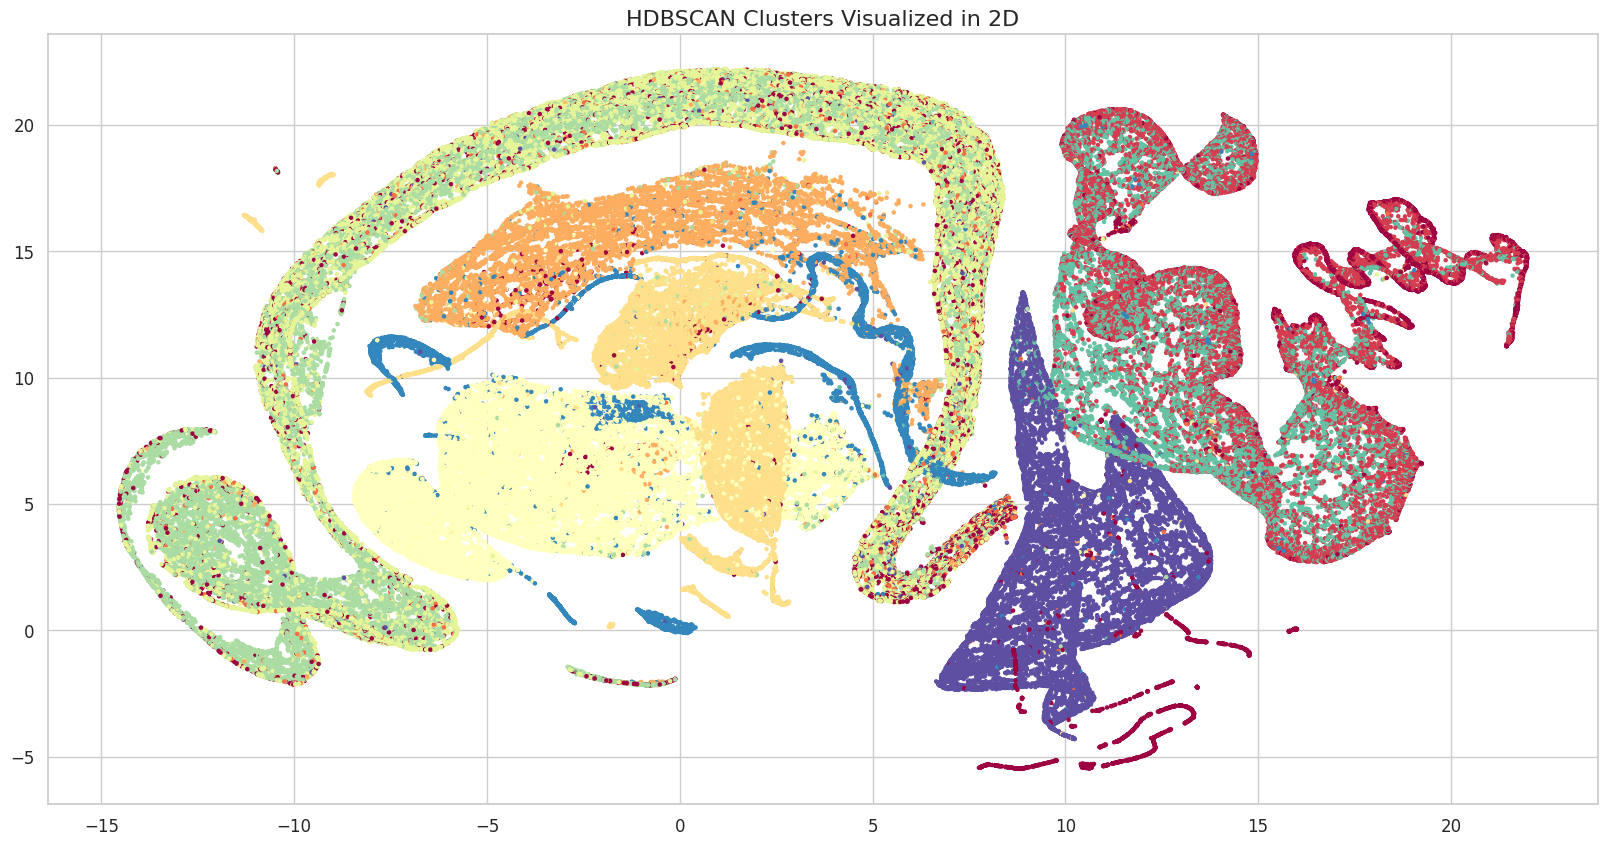

In [21]:
plt.scatter(X_umap_viz[:, 0], X_umap_viz[:, 1], c=labels, cmap='Spectral', s=5)
plt.title('HDBSCAN Clusters Visualized in 2D')
plt.show()

NameError: name 'best_model' is not defined

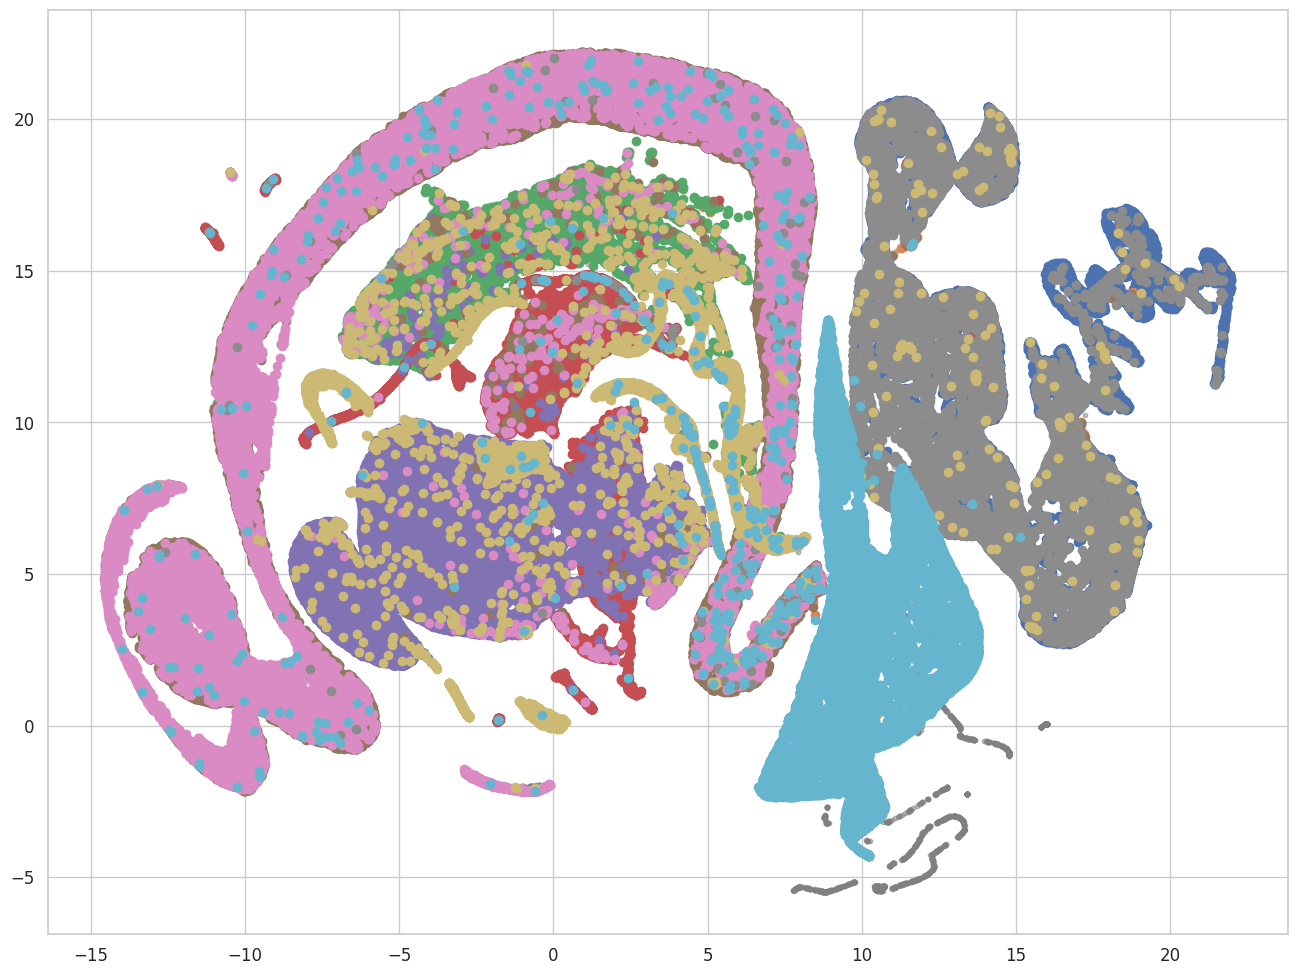

In [19]:
# Visualize the clusters in UMAP space
plt.figure(figsize=(16, 12))

# Create a custom colormap for clusters
n_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

# Plot each cluster
for i, cluster in enumerate(sorted(set(best_labels))):
    if cluster == -1:  # Noise points in some algorithms
        plt.scatter(umap_df[umap_df['Cluster'] == cluster]['UMAP1'],
                   umap_df[umap_df['Cluster'] == cluster]['UMAP2'],
                   s=10, c='gray', alpha=0.5, label='Noise')
    else:
        plt.scatter(umap_df[umap_df['Cluster'] == cluster]['UMAP1'],
                   umap_df[umap_df['Cluster'] == cluster]['UMAP2']
                    ,
                  #  s=30, c=[colors[i]], alpha=0.7, label=f'Cluster {cluster}'
                   )

plt.title(f'UMAP Visualization of {best_model} Clusters', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(title='Clusters', title_fontsize=12, fontsize=10, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('best_model_umap_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Cluster Analysis and Interpretation

In [24]:
# Add cluster labels to the original dataframe
df_with_clusters = df.copy()
# df_with_clusters['cluster'] = best_labels
df_with_clusters['cluster'] = labels
# Calculate cluster statistics
cluster_stats = df_with_clusters.groupby('cluster').mean()

# Display cluster sizes
cluster_sizes = df_with_clusters['cluster'].value_counts().sort_index()
print("Cluster sizes:")
print(cluster_sizes)

# Calculate percentage of total for each cluster
cluster_percentages = (cluster_sizes / len(df_with_clusters) * 100).round(2)
print("\nCluster percentages:")
print(cluster_percentages)

Cluster sizes:
cluster
-1    11567
 0    17781
 1     2027
 2    10516
 3    23402
 4    27846
 5    25644
 6    23487
 7    12546
 8    12140
 9    16610
Name: count, dtype: int64

Cluster percentages:
cluster
-1     6.30
 0     9.69
 1     1.10
 2     5.73
 3    12.75
 4    15.17
 5    13.97
 6    12.79
 7     6.83
 8     6.61
 9     9.05
Name: count, dtype: float64


<ipython-input-25-6f98e667467b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis')


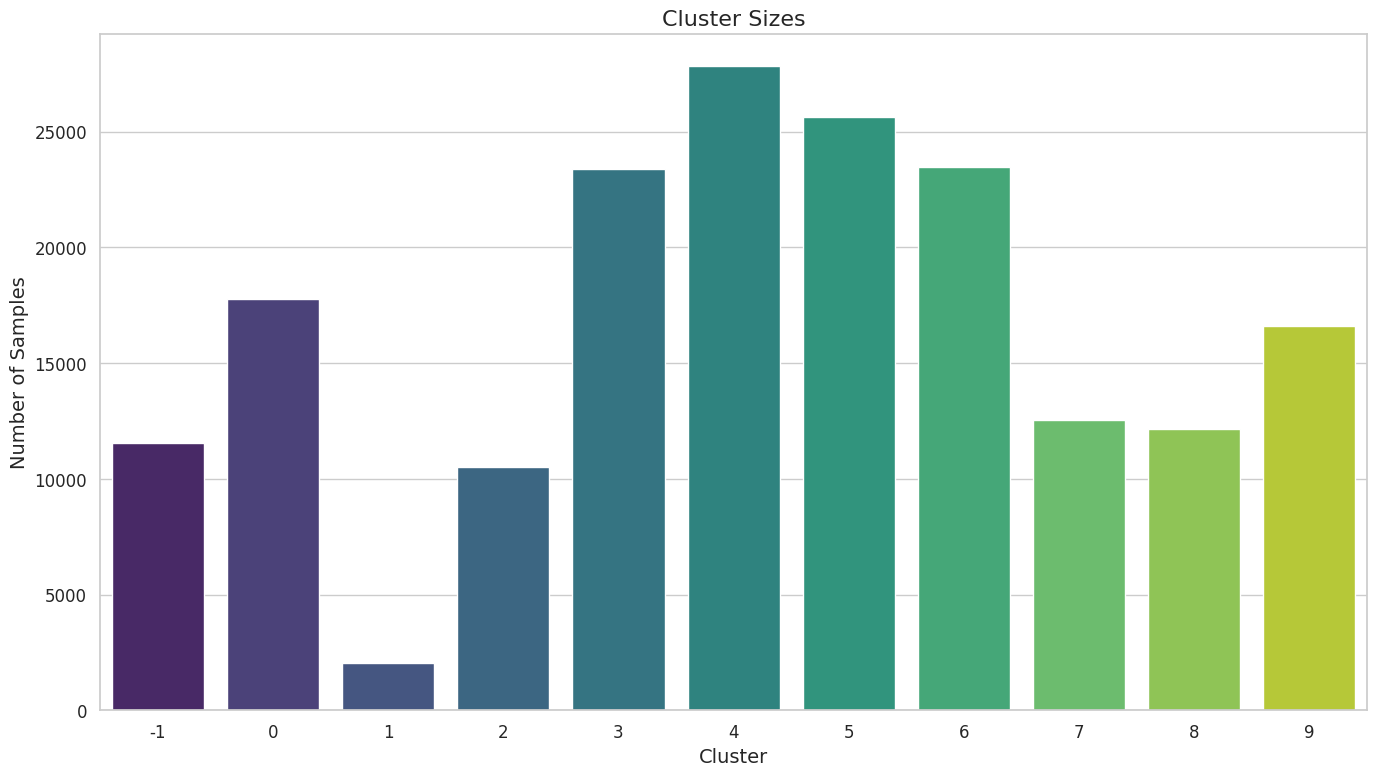

In [25]:
# Visualize cluster sizes
plt.figure(figsize=(14, 8))
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis')
plt.title('Cluster Sizes', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('cluster_sizes.png', dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-29-3d4ed72d94d6>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='pastel')


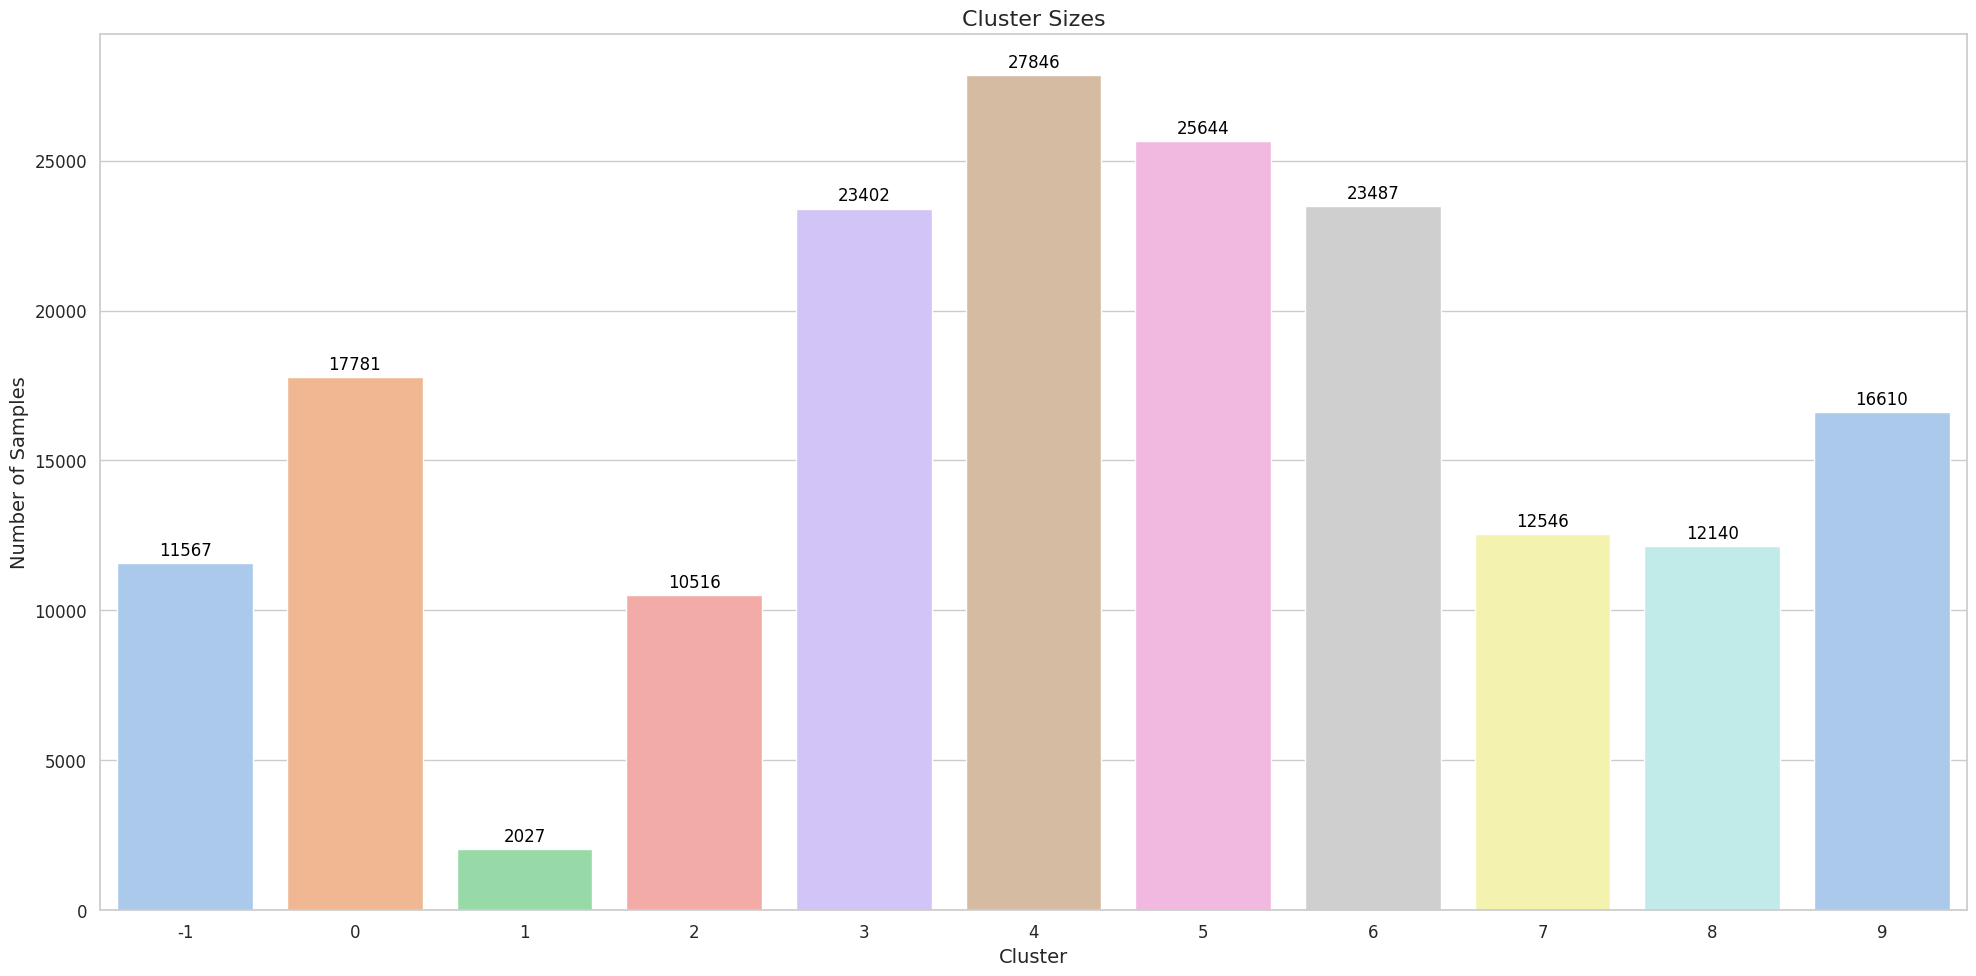

In [29]:
barplot = sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='pastel')

plt.title('Cluster Sizes', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()

# Ручное добавление подписей ко всем столбцам
for patch in barplot.patches:
    height = patch.get_height()
    if height > 0:  # можно добавить условие, чтобы не подписывать нулевые столбцы
        barplot.annotate(f'{int(height)}',
                         (patch.get_x() + patch.get_width() / 2, height),
                         ha='center', va='bottom',
                         fontsize=12, color='black', alpha=1,
                         xytext=(0, 3), textcoords='offset points')

plt.savefig('cluster_sizes.png', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
df['labels'] = labels
df

,Unnamed: 0,time_in_game_30d,cnt_active_days_30d,time_in_game_g,cnt_active_days_g,time_in_battles_30d,time_in_pvp_battles_30d,time_in_ranked_battles_30d,time_in_pve_battles_30d,time_in_event_battles_30d,...,battles_cnt_g,sse_done_cnt_30d,cnt_ach_30d,cnt_ach_g,usd_payed_30d,item_bought_cnt_30d,ships_cnt_g,ships_cnt_30d,sse_done_cnt_g,labels
0,0,7.12,1,243.57,13,0.00,0.00,0.00,0.0,0.0,...,23,1.0,0.0,0.0,0.00,0.0,0.0,0.0,2.0,0
1,1,376.80,29,9088.43,534,38.50,38.50,0.00,0.0,0.0,...,242,2.0,1.0,316.0,0.00,0.0,17.0,3.0,83.0,5
2,2,888.87,2,125431.92,776,308.22,187.45,120.77,0.0,0.0,...,4911,21.0,9.0,1263.0,0.00,0.0,33.0,1.0,2120.0,4
3,3,30.90,1,40997.42,207,19.37,19.37,0.00,0.0,0.0,...,2317,2.0,0.0,0.0,0.00,0.0,79.0,1.0,1116.0,5
4,4,3385.88,25,686714.78,2142,1522.13,736.75,0.00,0.0,0.0,...,21934,95.0,16.0,4407.0,0.00,0.0,58.0,7.0,9392.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183561,183561,318.02,4,318.02,4,184.30,180.68,0.00,0.0,0.0,...,21,2.0,13.0,0.0,0.00,0.0,0.0,0.0,0.0,5
183562,183562,247.25,2,247.25,2,138.98,125.07,0.00,0.0,0.0,...,22,0.0,11.0,0.0,0.00,0.0,0.0,0.0,0.0,5
183563,183563,20.67,2,20.67,2,4.20,0.00,0.00,0.0,0.0,...,1,0.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0,-1
183564,183564,44.52,1,44.52,1,25.05,5.33,0.00,0.0,0.0,...,5,1.0,2.0,0.0,0.00,0.0,0.0,0.0,0.0,-1


In [33]:
df = df.drop(columns='Unnamed: 0')

In [37]:
def radar_grapgh(df, col_name):

    cluster_names = df[col_name].unique()
    df = df.drop(col_name, axis=1)

    # Определяем категории (оси)
    categories = list(df.columns)
    num_vars = len(categories)

    # Угол для каждой категории
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Замыкаем круг

    # Рассчитываем минимальные и максимальные значения по всем кластерам для каждой оси
    min_vals = df.min(axis=0).values
    max_vals = df.max(axis=0).values

    # Определяем количество кластеров
    num_clusters = len(df)

    # Создаем подграфики с нужным количеством строк и столбцов
    rows = (num_clusters // 3) + (1 if num_clusters % 3 != 0 else 0)  # Расчет строк
    fig, axs = plt.subplots(rows, 3, figsize=(20, 5 * rows), subplot_kw=dict(polar=True))

    # Преобразуем axs в одномерный массив, чтобы удобнее было работать
    axs = axs.flatten()

    for i, cluster in enumerate(df.index):  # Для каждого кластера
        values = df.loc[cluster].values.flatten().tolist()
        values += values[:1]  # Замыкаем круг

        ax = axs[i]  # Выбираем подграфик
        ax.fill(angles, values, color="red", alpha=0.25)
        ax.plot(angles, values, color="red", linewidth=2)

        # Устанавливаем одинаковые оси для всех графиков
        ax.set_ylim(min(min_vals), max(max_vals))

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=10)
        ax.set_title(f"{cluster_names[i]}", y=1.1, fontweight='bold')

    # Поднимаем титул выше с помощью параметра y
    plt.suptitle("Радар-графики мотивации по кластерам", fontsize=16, y=1.03)  # Увеличиваем значение y для подъема титула
    plt.tight_layout()
    plt.figure(figsize=(40, 40))
    plt.show()

In [42]:
cluster_profiles_normalized

,time_in_game_30d,cnt_active_days_30d,time_in_game_g,cnt_active_days_g,time_in_battles_30d,time_in_pvp_battles_30d,time_in_ranked_battles_30d,time_in_pve_battles_30d,time_in_event_battles_30d,active_days_with_battles_30d,...,battles_cnt_g,sse_done_cnt_30d,cnt_ach_30d,cnt_ach_g,usd_payed_30d,item_bought_cnt_30d,ships_cnt_g,ships_cnt_30d,sse_done_cnt_g,labels
labels,,,,,,,,,,,,,,,,,,,,,
-1,0.071904,0.081947,0.068634,0.073457,0.072125,0.054894,0.011500,0.064101,1.000000,0.061344,...,0.062952,0.076878,0.051343,0.030925,0.125240,0.111031,0.074789,0.158812,0.065303,0.0
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.003285,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.1
1,0.014876,0.088816,0.114433,0.165711,0.010835,0.010079,0.000145,0.000187,0.004156,0.045269,...,0.111358,0.017250,0.008603,0.022312,0.013424,0.018650,0.172678,0.224821,0.103269,0.2
2,0.294597,0.452081,0.176687,0.237699,0.286323,0.476202,0.000745,0.001437,0.694824,0.429963,...,0.174455,0.269841,0.265378,0.172989,0.145993,0.194526,0.367175,0.660210,0.170042,0.3
3,0.791382,0.874496,0.551754,0.625263,0.793341,0.596875,0.380629,1.000000,0.684900,0.846491,...,0.579592,0.776006,0.595692,0.525679,0.582032,0.667890,0.757726,0.923964,0.559344,0.4
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.006366,0.523958,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.5
5,0.192924,0.327440,0.090915,0.138527,0.196463,0.363065,0.000286,0.000480,0.003207,0.310440,...,0.096026,0.145255,0.246218,0.093562,0.003143,0.004054,0.204389,0.447222,0.085031,0.6
6,0.425046,0.587585,0.531901,0.625196,0.409172,0.771395,0.000468,0.000658,0.003766,0.523313,...,0.512036,0.399182,0.306579,0.460399,0.473393,0.550612,0.653550,0.742616,0.499050,0.7
7,0.123646,0.539319,0.085329,0.232247,0.112145,0.000068,0.000312,0.000148,0.000889,0.248544,...,0.116896,0.101706,0.003097,0.002388,0.000286,0.000251,0.276593,0.589023,0.088246,0.8


labels


,time_in_game_30d,cnt_active_days_30d,time_in_game_g,cnt_active_days_g,time_in_battles_30d,time_in_pvp_battles_30d,time_in_ranked_battles_30d,time_in_pve_battles_30d,time_in_event_battles_30d,active_days_with_battles_30d,...,days_from_payment_btl_g,battles_cnt_g,sse_done_cnt_30d,cnt_ach_30d,cnt_ach_g,usd_payed_30d,item_bought_cnt_30d,ships_cnt_g,ships_cnt_30d,sse_done_cnt_g
labels,,,,,,,,,,,,,,,,,,,,,
-1,0.071904,0.081947,0.068634,0.073457,0.072125,0.054894,0.011500,0.064101,1.000000,0.061344,...,0.811782,0.062952,0.076878,0.051343,0.030925,0.125240,0.111031,0.074789,0.158812,0.065303
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.003285,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.014876,0.088816,0.114433,0.165711,0.010835,0.010079,0.000145,0.000187,0.004156,0.045269,...,0.640639,0.111358,0.017250,0.008603,0.022312,0.013424,0.018650,0.172678,0.224821,0.103269
2,0.294597,0.452081,0.176687,0.237699,0.286323,0.476202,0.000745,0.001437,0.694824,0.429963,...,0.605548,0.174455,0.269841,0.265378,0.172989,0.145993,0.194526,0.367175,0.660210,0.170042
3,0.791382,0.874496,0.551754,0.625263,0.793341,0.596875,0.380629,1.000000,0.684900,0.846491,...,0.358226,0.579592,0.776006,0.595692,0.525679,0.582032,0.667890,0.757726,0.923964,0.559344
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.006366,0.523958,1.000000,...,0.191277,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.192924,0.327440,0.090915,0.138527,0.196463,0.363065,0.000286,0.000480,0.003207,0.310440,...,0.997434,0.096026,0.145255,0.246218,0.093562,0.003143,0.004054,0.204389,0.447222,0.085031
6,0.425046,0.587585,0.531901,0.625196,0.409172,0.771395,0.000468,0.000658,0.003766,0.523313,...,0.007387,0.512036,0.399182,0.306579,0.460399,0.473393,0.550612,0.653550,0.742616,0.499050
7,0.123646,0.539319,0.085329,0.232247,0.112145,0.000068,0.000312,0.000148,0.000889,0.248544,...,0.999919,0.116896,0.101706,0.003097,0.002388,0.000286,0.000251,0.276593,0.589023,0.088246


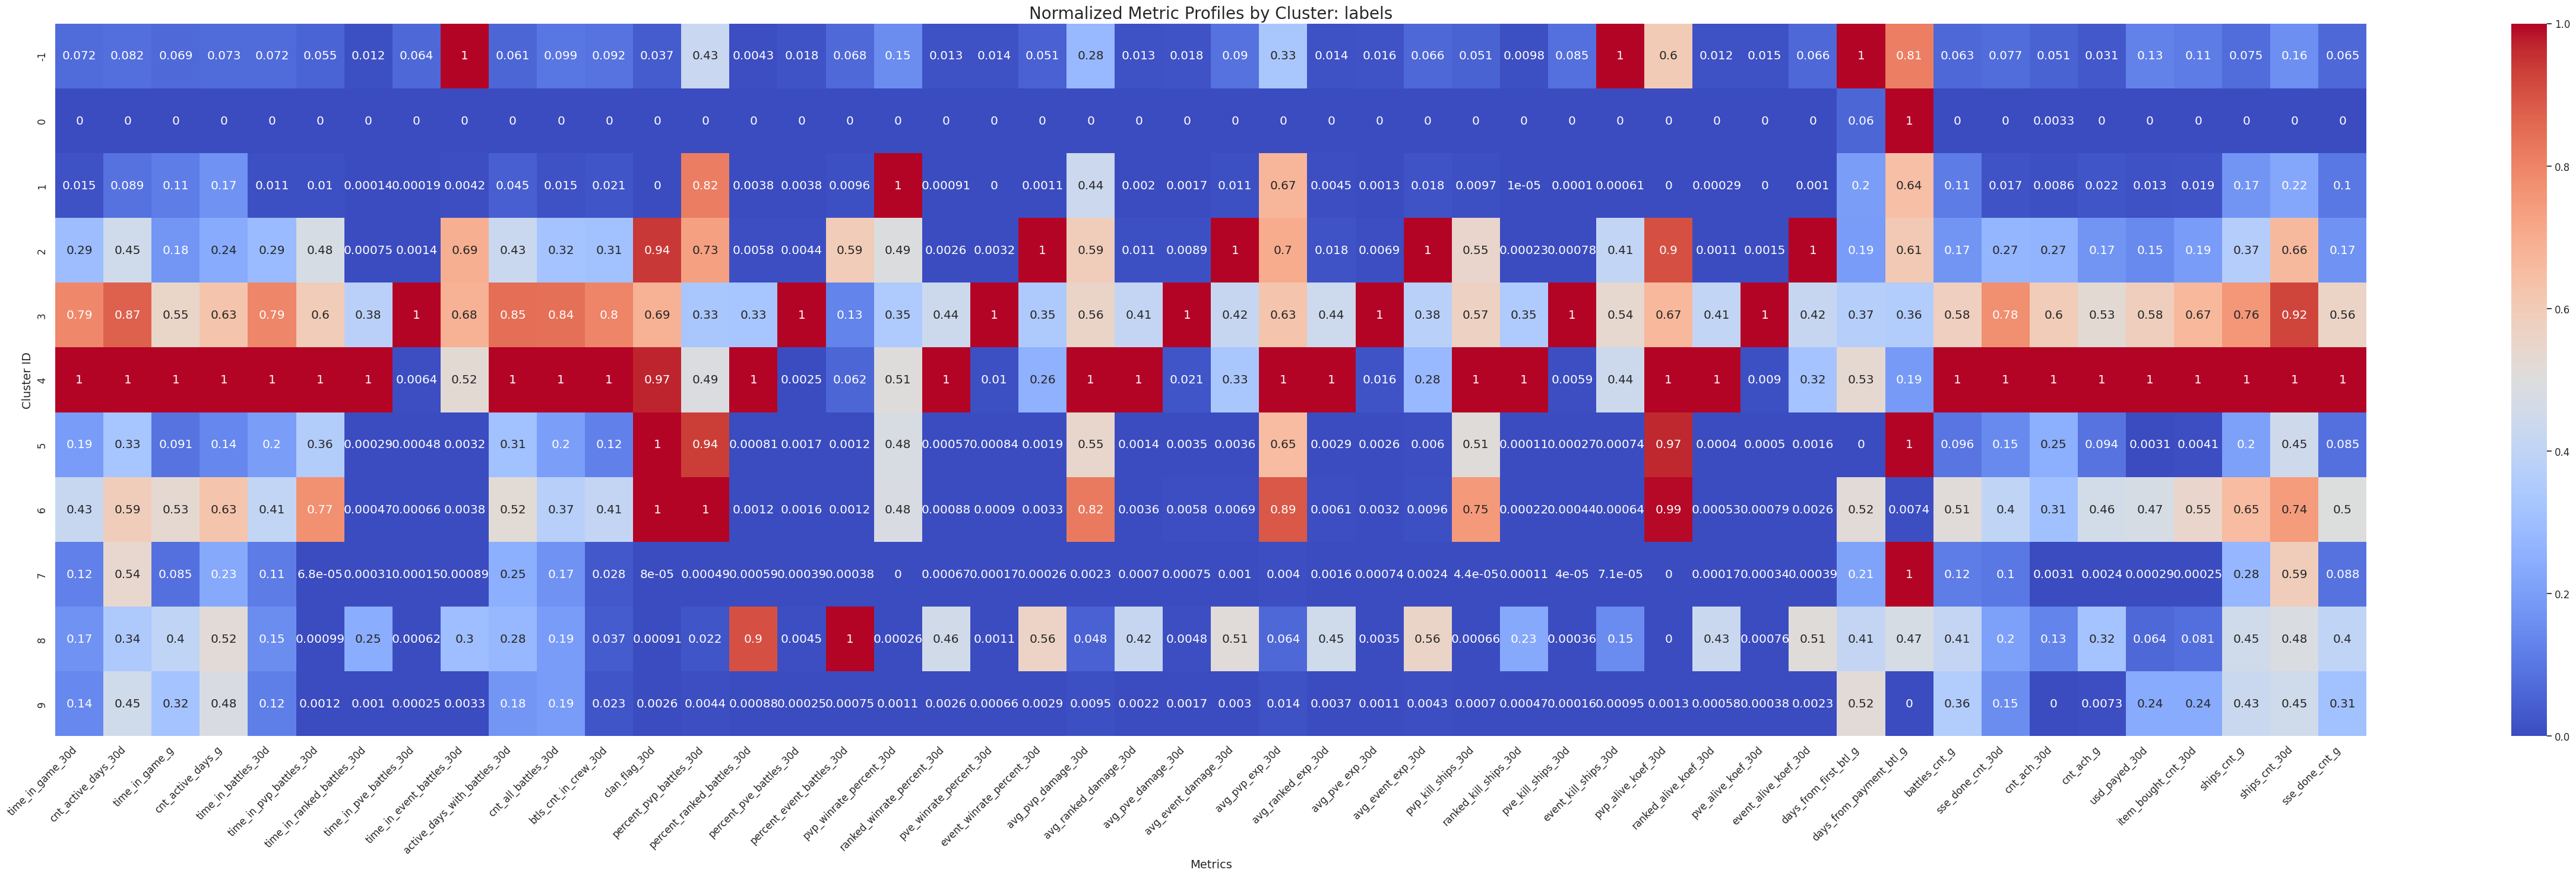

In [52]:
from sklearn.preprocessing import MinMaxScaler

# Function to normalize a DataFrame using Min-Max scaling
def normalize_dataframe(df):
    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Select only numeric columns ending with '_g'
feature_columns = [
    col for col in df.select_dtypes(include='number').columns
    if 'labels' not in col
]

# Iterate through each clustering column
for cluster_col in df.filter(regex='labels').columns:
    print(cluster_col)
    # Compute mean values per cluster
    cluster_profiles = df.groupby(cluster_col)[feature_columns].mean()

    # Normalize values to [0, 1]
    cluster_profiles_normalized = normalize_dataframe(cluster_profiles)

    # Reset index for radar plot
    # cluster_profiles_reset = cluster_profiles_normalized.reset_index()

    # Display the normalized cluster profiles
    display(cluster_profiles_normalized)

    # Radar chart (assumes your function handles DataFrame with cluster_col in index)
    # radar_grapgh(cluster_profiles_reset, cluster_col)

    # Heatmap visualization
    plt.figure(figsize=(50, 15))
    sns.heatmap(cluster_profiles_normalized, annot=True, cmap='coolwarm')
    plt.title(f'Normalized Metric Profiles by Cluster: {cluster_col}', fontsize=20)
    plt.xlabel('Metrics', fontsize=14)
    plt.ylabel('Cluster ID', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [51]:
feature_columns

['time_in_game_30d',
 'cnt_active_days_30d',
 'time_in_game_g',
 'cnt_active_days_g',
 'time_in_battles_30d',
 'time_in_pvp_battles_30d',
 'time_in_ranked_battles_30d',
 'time_in_pve_battles_30d',
 'time_in_event_battles_30d',
 'active_days_with_battles_30d',
 'cnt_all_battles_30d',
 'btls_cnt_in_crew_30d',
 'clan_flag_30d',
 'percent_pvp_battles_30d',
 'percent_ranked_battles_30d',
 'percent_pve_battles_30d',
 'percent_event_battles_30d',
 'pvp_winrate_percent_30d',
 'ranked_winrate_percent_30d',
 'pve_winrate_percent_30d',
 'event_winrate_percent_30d',
 'avg_pvp_damage_30d',
 'avg_ranked_damage_30d',
 'avg_pve_damage_30d',
 'avg_event_damage_30d',
 'avg_pvp_exp_30d',
 'avg_ranked_exp_30d',
 'avg_pve_exp_30d',
 'avg_event_exp_30d',
 'pvp_kill_ships_30d',
 'ranked_kill_ships_30d',
 'pve_kill_ships_30d',
 'event_kill_ships_30d',
 'pvp_alive_koef_30d',
 'ranked_alive_koef_30d',
 'pve_alive_koef_30d',
 'event_alive_koef_30d',
 'days_from_first_btl_g',
 'days_from_payment_btl_g',
 'battles

## 10. Save Results and Models

In [ ]:
# Save the data with cluster assignments
df_with_clusters.to_csv('data_with_clusters.csv', index=False)
print("Data with cluster assignments saved to 'data_with_clusters.csv'")

# Save the cluster statistics
cluster_stats.to_csv('cluster_statistics.csv')
print("Cluster statistics saved to 'cluster_statistics.csv'")

# Save the z-scores for feature importance
z_scores_df.to_csv('cluster_feature_importance.csv')
print("Cluster feature importance saved to 'cluster_feature_importance.csv'")

## 11. Conclusion and Next Steps

In this notebook, we've implemented a comprehensive clustering analysis pipeline that includes:

1. Data preprocessing and exploration
2. Preparation of multiple dataset variants (standardized, VIF-filtered, PCA, UMAP)
3. Implementation of multiple clustering algorithms with various parameters
4. Advanced evaluation metrics including negentropy and minimum cluster size ratio
5. UMAP stability analysis
6. Comprehensive comparison of all models across all datasets
7. Visualization of the best clustering model using UMAP
8. Analysis and interpretation of cluster characteristics

The best performing model based on silhouette score was [model name] on the [dataset] dataset, which identified [number] distinct clusters in the data.

### Potential next steps:

1. Further tune the parameters of the best performing model
2. Develop a classification model to predict cluster membership for new data
3. Conduct a deeper business analysis of each cluster to derive actionable insights
4. Implement a monitoring system to track cluster stability over time
5. Explore additional dimensionality reduction techniques for visualization